In [18]:
import os
import sys
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw, ImageSequence
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, to_pil_image

sys.path.append(r'/home/declan/Documents/Projects/CS639-FinalProject/src/classification/')
from dataset import FaceDataset
from policy import Policy
from utils import StateObject

In [19]:
def plot_views(images, visited_idxes, filename):
    n_views = len(visited_idxes)
    n_imgs = images.shape[0]
    i_img = random.randint(1, n_imgs-1)
    orig_img = to_pil_image(images[i_img])
    visited_idxes = visited_idxes[1:]
    imgs = np.dstack([idxes[i_img].reshape([16, 16]) for idxes in visited_idxes])
    heat_map = np.sum(imgs, axis=2, dtype=int)
    heat_map = heat_map.repeat(32, axis=0).repeat(32, axis=1) # upsample to (512 x 512)
    heat_map_mask = np.logical_not(np.dstack([heat_map, heat_map, heat_map]))
    heat_map = np.dstack([np.zeros([512, 512], dtype=int), heat_map, np.zeros([512, 512], dtype=int)]) # make green squares.
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
    img_with_heat_map = np.asarray(orig_img)*heat_map_mask+heat_map*255
    axes.imshow(img_with_heat_map.astype(np.uint8))
    axes.axis('off')
    plt.tight_layout()
    plt.savefig(filename)

In [20]:
def create_view_gif(images, visited_idxes, gifname):
    
    # Draws a square on the given image.
    def draw_square_from_idx(img, idx):
        i = idx % 16
        j = idx // 16
        x1 = i*32
        x2 = (i+1)*32-1
        y1 = j*32
        y2 = (j+1)*32-1
        draw = ImageDraw.Draw(img, mode='RGB')
        draw.rectangle(((x1, y1), (x2, y2)), fill=(0, 255, 0))
        return img
    
    n_views = len(visited_idxes)
    n_imgs = images.shape[0]
    i_img = random.randint(0, n_imgs-1)
    orig_img = to_pil_image(images[i_img])
    padding = (10, 10, 10, 10)
    # New img.
    total_width = 512+20
    max_height = 512+20
    final_imgs = [] # Stores list of concatenated images.
    for i_view in range(-1, n_views): #### CHANGE THIS LATER.
        new_img = Image.new('RGB', (total_width, max_height)) # Concatenated image.
        # First add a blank image.
        if i_view == -1:
            orig_img_padded = ImageOps.expand(orig_img.copy(), padding, fill=(255,255,255))
            blank_img = Image.new('RGB', (532, 532)) #, fill=(255,255,255))
            new_img.paste(orig_img_padded, (0, 0))
            final_imgs.append(new_img)
            continue
        # idx is always (0,0) if first i_view.
        elif i_view == 0:
            idx = 0
        # Otherwise, the get the idx of the max view.
        else:
            idx = np.argmax(visited_idxes[i_view][i_img])
        # Draw the image.
        orig_img = draw_square_from_idx(orig_img, idx)
        orig_img_padded = ImageOps.expand(orig_img.copy(), padding, fill=(255,255,255))
        new_img.paste(orig_img_padded, (0, 0))
        final_imgs.append(new_img)
    final_imgs[0].save(gifname, save_all=True, append_images=final_imgs[1:], duration=500, loop=0)

In [11]:
class Agent():
    """
    This agent implements the policy from Policy class and uses REINFORCE / Actor-Critic for policy improvement
    """
    def __init__(self):
        super(Agent, self).__init__()
        self.policy = Policy().to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.iscuda = True
        
        # Maybe not necessary.
        self.R_avg = 0
        self.avg_count = 0
        self.reward_scale = 1
        self.lambda_entropy = 1e-1
        self.selection_type = 'notgreedy'


    def gather_trajectory(self, state_object):
        """
        gather_trajectory gets an observation, updates it's belief of the state, decodes the
        panorama and takes the next action. This is done repeatedly for T time steps.
        Note:
        eval_opts are provided only during testing
        """

        # Setup variables to store trajectory information.
        self.T = 10
        rewards = []
        log_probs = []
        errs = []
        actions = []
        entropies = []
        self.avg_count = 0
        hidden = None
        visited_idxes = []
        batch_size = state_object.batch_size
        decoded_all = []
        actions_taken = torch.zeros([batch_size, self.T-1])
        action_probs = None
        acts = None
        
        # NOTE: EXPERIMENTAL.
        views = torch.zeros([batch_size, 256], requires_grad=False, dtype=int).to(device)
        
        for t in range(self.T):
            # At first iteration, action probs==None, so state_object returns a fixed view at (0,0).
            im, pro = state_object.get_view(acts) ##### THIS WAS CHANGED. ######
            im, pro = torch.Tensor(im), torch.Tensor(pro)
            visited_idxes.append(state_object.index)
            policy_input = {'im': im, 'pro': pro}
            
            # Update if using CUDA.
            if self.iscuda:
                for var in policy_input:
                    policy_input[var] = policy_input[var].cuda()
            
            # Otherwise use the CPU.
            else:
                for var in policy_input:
                    policy_input[var] = Variable(policy_input[var])

            # Note: decoded and hidden correspond to the previous transition
            # probs and value correspond to the new transition, where the value
            # and action probabilities of the current state are estimated for PG update.
            action_probs, hidden, decoded = self.policy.forward(policy_input, views.clone().type(torch.float32), hidden=hidden)
            decoded_all.append(decoded)
            # Compute reconstruction loss (corresponding to the previous transition).
            err = F.binary_cross_entropy(decoded, state_object.features.to(device))
            self.optimizer.zero_grad()
            nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
            err.backward(retain_graph=True)
            self.optimizer.step()

            # Reconstruction reward is obtained only at the final step
            # If there is only one step (T=1), then do not provide rewards
            # Note: This reward corresponds to the previous action
            if t == 0:
                reward = torch.zeros(batch_size)
                if self.iscuda:
                    reward = reward.cuda()
            else:
                reward = -err.data # Disconnects reward from future updates
                self.R_avg = (self.R_avg * self.avg_count + reward.sum()) / (self.avg_count + batch_size)
                self.avg_count += batch_size
            if t > 0:
                rewards[t-1] += reward
                
            # There are self.T reconstruction errors as opposed to self.T-1 rewards
            errs.append(err)

            # Sample action except for the last time step when only the selected view from previous step is used in aggregate.
            if t < self.T - 1:
                # Act based on the policy network
                if self.selection_type != 'greedy':
                    acts = action_probs.multinomial(num_samples=1).data
                else:
                    # This works only while evaluating, not while training
                    _, acts = action_probs.max(dim=1)
                    acts = acts.data.view(-1, 1)
                
                # Compute entropy
                entropy = -(action_probs*((action_probs+1e-7).log())).sum(dim=1)
                # Store log probabilities of selected actions (Advanced indexing).
                log_prob = (action_probs[range(acts.size(0)), acts[:, 0]]+1e-7).log() # Save log_probs of choosing selected actions.

                # This is the intrinsic reward corresponding to the current action
                actions.append(acts)
                rewards.append(reward)
                log_probs.append(log_prob)
                entropies.append(entropy)

        return log_probs, errs, rewards, entropies, decoded, visited_idxes, decoded_all, actions_taken
    
    
    def update_policy(self, rewards, log_probs, entropies, task_errs=None, values=None):
        """
        This function will take the rewards, log probabilities and task-specific errors from
        the trajectory and perform the parameter updates for the policy using REINFORCE.
        INPUTS:
            rewards: list of T-1 Tensors containing reward for each batch at each time step.
            log_probs: list of T-1 logprobs Variables of each transition of batch.
            task_errs: list of T error Variables for each transition of batch.
            entropies: list of T-1 entropy Variables for each transition of batch.
            values: list of T-1 predicted values Variables for each transition of batch.
        """
        # ---- Setup initial values ----
        batch_size = rewards[0].size(0)
        R = torch.zeros(batch_size) # Reward accumulator
        B = 0 # Baseline accumulator - used primarily for the average baseline case
        loss = Variable(torch.Tensor([0]))
        if self.iscuda:
            loss = loss.cuda()
            R = R.cuda()
    
        # REINFORCE loss based on T-1 transitions.
        # Note: This will automatically be ignored when self.T = 1
        for t in reversed(range(self.T-1)):
            R = R + rewards[t] # A one sample MC estimate of Q[t]
            # PG loss
            loss_term_1 = -(log_probs[t]*self.reward_scale).sum()/batch_size
            # Entropy loss, maximize entropy
            loss_term_2 = -self.lambda_entropy*entropies[t].sum()/batch_size
            loss = loss + loss_term_1 + loss_term_2
    
        self.optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
        self.optimizer.step()

In [12]:
def generate_train_test_dfs(train_ratio):
    attribute_file = 'CelebAMask-HQ-attribute-anno.txt'
    datadir = '/home/declan/Data/Faces/'
    img_dir = os.path.join(datadir, 'CelebA-HQ-img')
    attr_dir = os.path.join(datadir, 'CelebAMask-HQ-attribute-anno.txt')
    attributes = pd.read_csv(attr_dir, delimiter=' ')
    good_data = attributes[['Bald', 'Wearing_Hat', 'Gray_Hair']] #['Bald', 'Smiling', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necktie', 'Wearing_Necklace', 'Gray_Hair', 'Eyeglasses']
    good_data = good_data.clip(lower=0) # Set -1 to 0.
    good_data = good_data[(good_data.T != 0).any()] # drop any rows with only zeros.
    good_data = good_data.sample(frac=1) # Shuffle dataframe.
    n_train_imgs = int(good_data.shape[0]*train_ratio)
    train_data = good_data.iloc[:n_train_imgs, :]
    test_data = good_data.iloc[n_train_imgs:, :]
    return train_data, test_data

In [13]:
def evaluate(policy, state_object):
    """
    gather_trajectory gets an observation, updates it's belief of the state, decodes the
    panorama and takes the next action. This is done repeatedly for T time steps.
    Note:
    eval_opts are provided only during testing
    """

    # Setup variables to store trajectory information.
    iscuda=True
    T = 10
    errs = []
    visited_idxes = []
    batch_size = state_object.batch_size
    decoded_all = []
    hidden = None
    acts = None
    
    # NOTE: EXPERIMENTAL.
    views = torch.zeros([batch_size, 256]).to(device)
    
    for t in range(T):
        # At first iteration, action probs==None, so state_object returns a fixed view at (0,0).
        im, pro = state_object.get_view(acts)
        im, pro = torch.Tensor(im), torch.Tensor(pro)
        
        # Keep track of visited locations
        visited_idxes.append(state_object.index)

        # ---- Policy forward pass ----
        policy_input = {'im': im, 'pro': pro}
        
        # Update if using CUDA.
        if iscuda:
            for var in policy_input:
                policy_input[var] = policy_input[var].cuda()
        
        # Otherwise use the CPU.
        for var in policy_input:
            policy_input[var] = Variable(policy_input[var])
            
        action_probs, hidden, decoded = policy.forward(policy_input, views.clone().type(torch.float32), hidden=hidden)
        err = F.binary_cross_entropy(decoded, state_object.features.to(device))
        errs.append(err)
        decoded_all.append(decoded)
        
        _, acts = action_probs.max(dim=1)
        acts = acts.data.view(-1, 1)
        
        # NOTE: THIS NEXT LINE IS EXPERIMENTAL.
        if t>0:
            views[range(acts.size(0)), acts[:, 0]] = 1
        
    return errs, visited_idxes

In [14]:
def test(policy, dataloader, epoch):
    epoch_total_loss = 0.0
    policy.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            images, features = data
            state_object = StateObject(images, features)
            if images.shape[0] != 32:
                continue
            errs, visited_idxes = evaluate(policy, state_object)
            
            # Update loss tracker.
            errs = [err.cpu().detach().numpy() for err in errs] # Always detach variables from the graph :()
            loss = sum(errs)/len(errs)
            epoch_total_loss = epoch_total_loss + loss
            
            # Only save one example at the end of the epoch.
            if batch_idx%50 == 0:
                gifname = './Output/E'+str(epoch)+'B'+str(batch_idx)+'.gif'
                figname = './Output/E'+str(epoch)+'B'+str(batch_idx)+'.svg'
                create_view_gif(images, visited_idxes, gifname)
                plot_views(images, visited_idxes, figname)
        print('Epoch {} Test Loss: {:.4f}'.format(epoch, epoch_total_loss))

In [15]:
def train(agent, dataloader, epoch):
    epoch_total_loss = 0.0
    agent.policy.train()
    for batch_idx, data in enumerate(dataloader):
        images, features = data
        state_object = StateObject(images, features)
        if images.shape[0] != 32:
            continue
        log_probs, errs, rewards, entropies, decoded, visited_idxes, decoded_all, _ = agent.gather_trajectory(state_object)
        agent.update_policy(rewards, log_probs, entropies)
        # Print useful info.
        errs = [err.cpu().detach().numpy() for err in errs] # Always detach variables from the graph :()
        loss = sum(errs)/len(errs)
        epoch_total_loss = epoch_total_loss + loss
    print('Epoch {} Train Loss: {:.4f}'.format(epoch, epoch_total_loss))

In [16]:
device = 'cuda'
torch.backends.cudnn.benchmark = True
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 8}

# Set up the Datasets and the DataLoaders.
train_data, test_data = generate_train_test_dfs(.8)
transforms_ = transforms.Compose([transforms.Resize(size=(512, 512)) , transforms.ToTensor()])
train_dataset = FaceDataset(train_data, transforms=transforms_)
test_dataset = FaceDataset(test_data, transforms=transforms_)
train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

# Set up the model and the optimizer.
agent = Agent()
#state_dict = torch.load('../model_all_upd.pkl', map_location='cpu')
#agent.policy.load_state_dict(state_dict['model_state_dict'])

Epoch 0 Train Loss: 44.0368
Epoch 0 Test Loss: 11.4817
Epoch 1 Train Loss: 43.8683
Epoch 1 Test Loss: 11.1824
Epoch 2 Train Loss: 43.9498
Epoch 2 Test Loss: 11.3063
Epoch 3 Train Loss: 43.8140
Epoch 3 Test Loss: 11.3105
Epoch 4 Train Loss: 43.7482
Epoch 4 Test Loss: 11.0908
Epoch 5 Train Loss: 43.8345
Epoch 5 Test Loss: 11.5335
Epoch 6 Train Loss: 43.7912
Epoch 6 Test Loss: 11.0960
Epoch 7 Train Loss: 43.5250
Epoch 7 Test Loss: 11.7280
Epoch 8 Train Loss: 43.6391
Epoch 8 Test Loss: 10.7310
Epoch 9 Train Loss: 43.4535
Epoch 9 Test Loss: 10.8155
Epoch 10 Train Loss: 43.4680
Epoch 10 Test Loss: 10.9366
Epoch 11 Train Loss: 43.3157
Epoch 11 Test Loss: 11.5169
Epoch 12 Train Loss: 43.4127
Epoch 12 Test Loss: 11.2467
Epoch 13 Train Loss: 43.1280
Epoch 13 Test Loss: 10.5141
Epoch 14 Train Loss: 43.1551
Epoch 14 Test Loss: 10.5455
Epoch 15 Train Loss: 43.1662
Epoch 15 Test Loss: 11.4637
Epoch 16 Train Loss: 43.5143
Epoch 16 Test Loss: 10.8434
Epoch 17 Train Loss: 43.1927
Epoch 17 Test Loss: 11

/home/declan/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


Epoch 20 Test Loss: 10.9250
Epoch 21 Train Loss: 43.0776
Epoch 21 Test Loss: 11.3243
Epoch 22 Train Loss: 42.9727
Epoch 22 Test Loss: 11.0013
Epoch 23 Train Loss: 42.7999
Epoch 23 Test Loss: 11.0396
Epoch 24 Train Loss: 42.9681
Epoch 24 Test Loss: 10.6312
Epoch 25 Train Loss: 42.8563
Epoch 25 Test Loss: 10.7245
Epoch 26 Train Loss: 43.1132
Epoch 26 Test Loss: 10.7786
Epoch 27 Train Loss: 42.8003
Epoch 27 Test Loss: 10.7801
Epoch 28 Train Loss: 42.9396
Epoch 28 Test Loss: 10.9278
Epoch 29 Train Loss: 43.0656
Epoch 29 Test Loss: 10.5378
Epoch 30 Train Loss: 43.2556
Epoch 30 Test Loss: 10.9876
Epoch 31 Train Loss: 43.1213
Epoch 31 Test Loss: 10.6824
Epoch 32 Train Loss: 42.9012
Epoch 32 Test Loss: 10.9918
Epoch 33 Train Loss: 42.6222
Epoch 33 Test Loss: 11.0162
Epoch 34 Train Loss: 42.4356
Epoch 34 Test Loss: 11.1268
Epoch 35 Train Loss: 42.5656
Epoch 35 Test Loss: 11.3303
Epoch 36 Train Loss: 42.4966
Epoch 36 Test Loss: 11.3947
Epoch 37 Train Loss: 42.7143
Epoch 37 Test Loss: 11.2299
Epo

KeyboardInterrupt: 

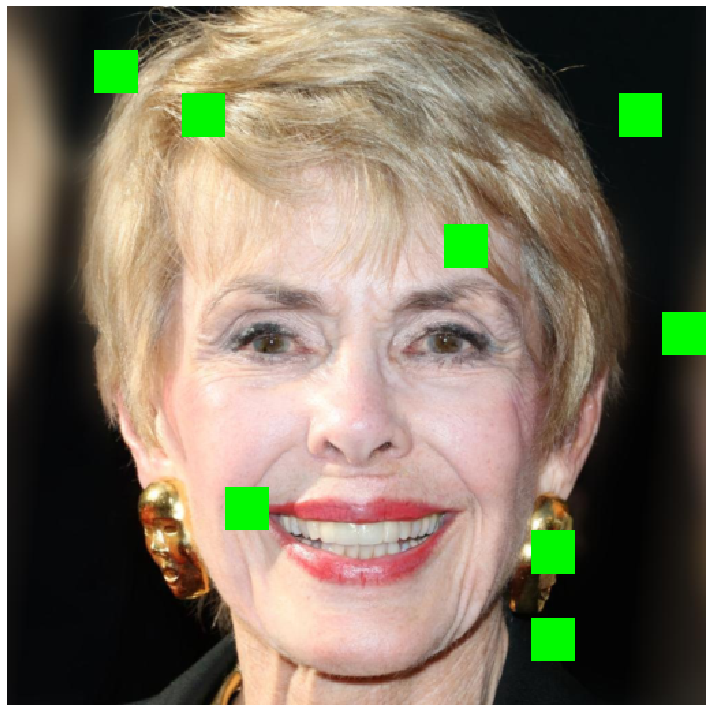

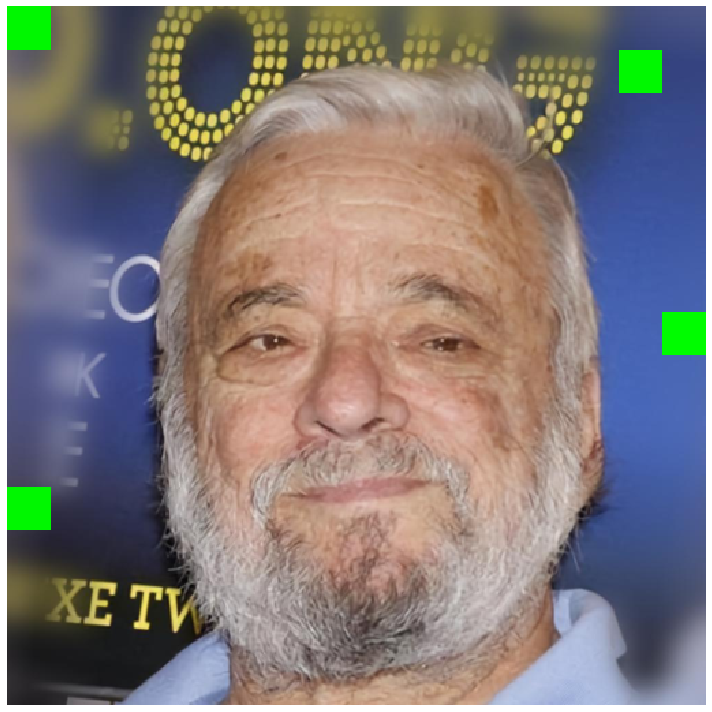

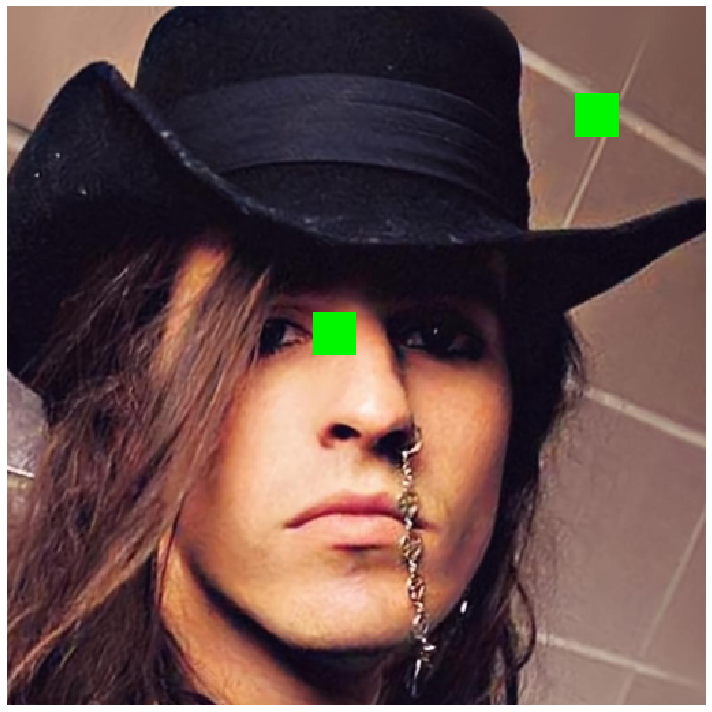

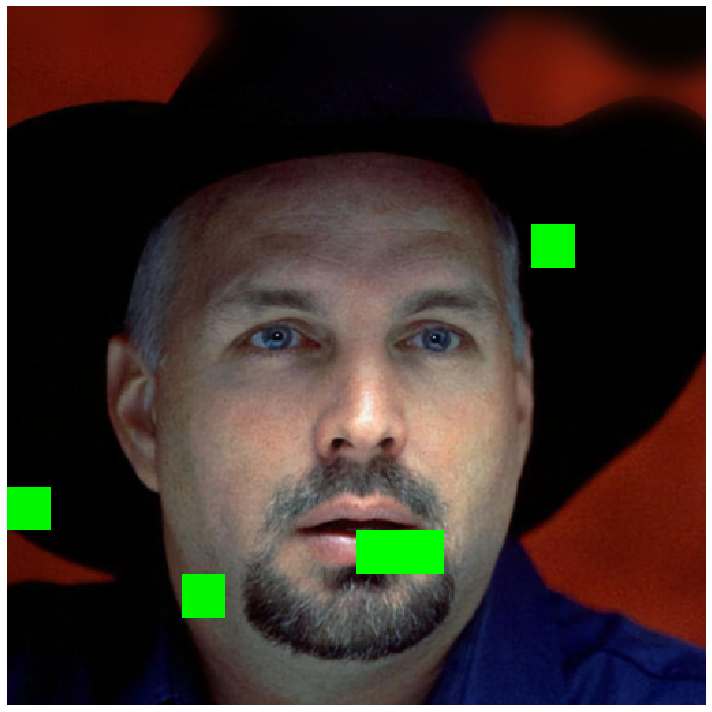

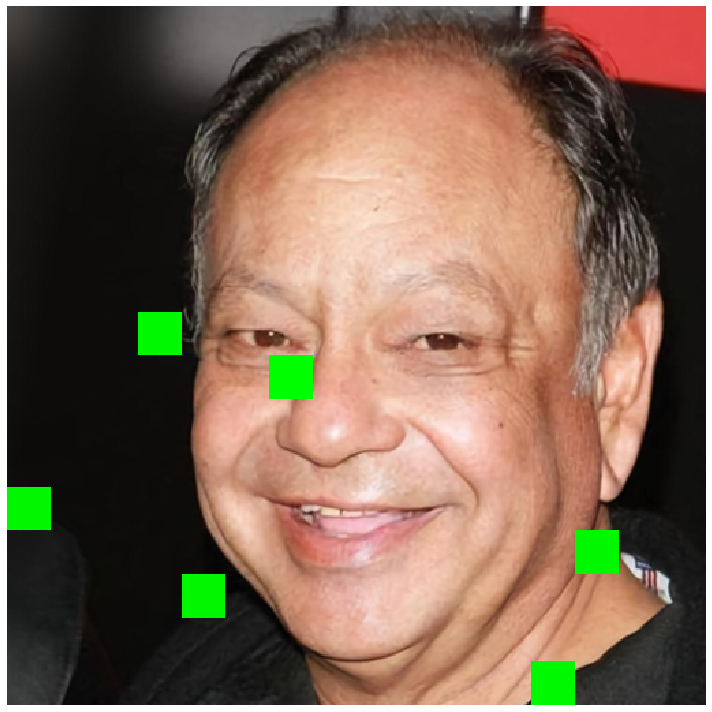

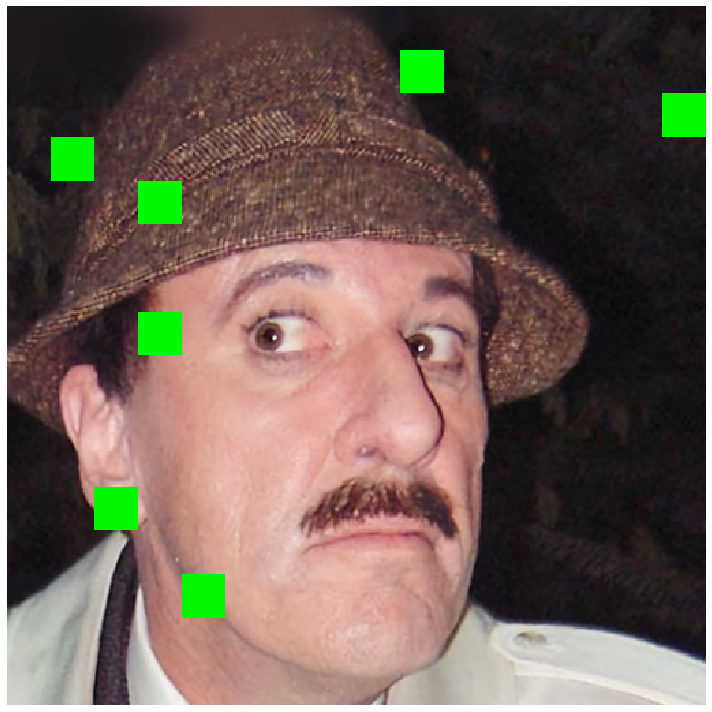

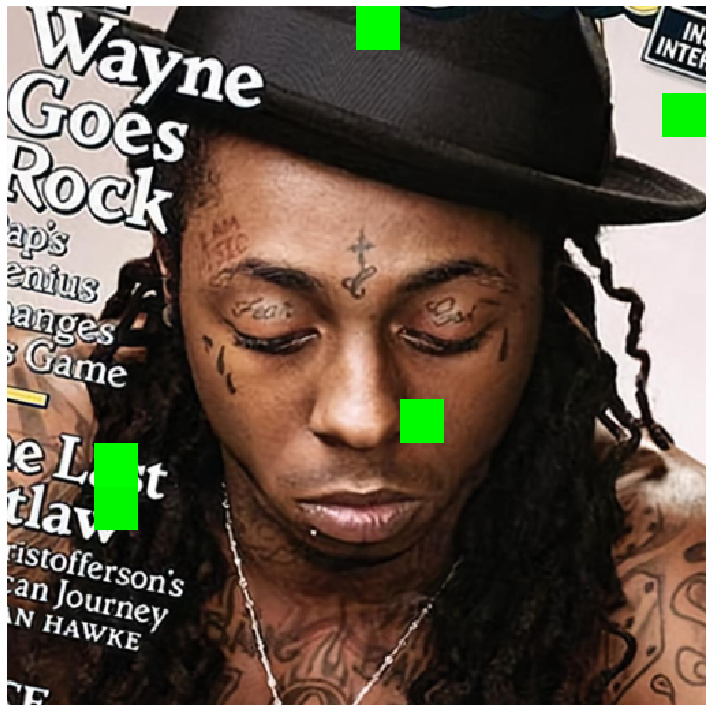

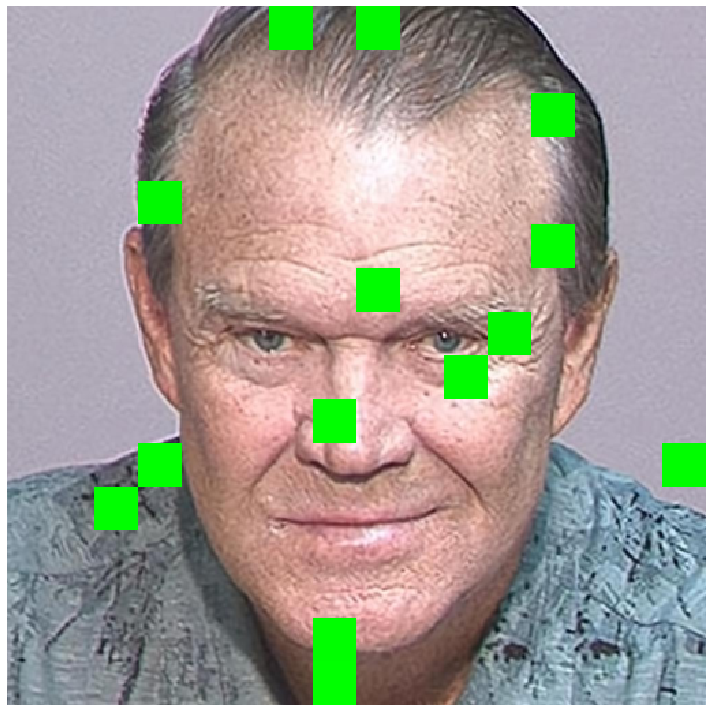

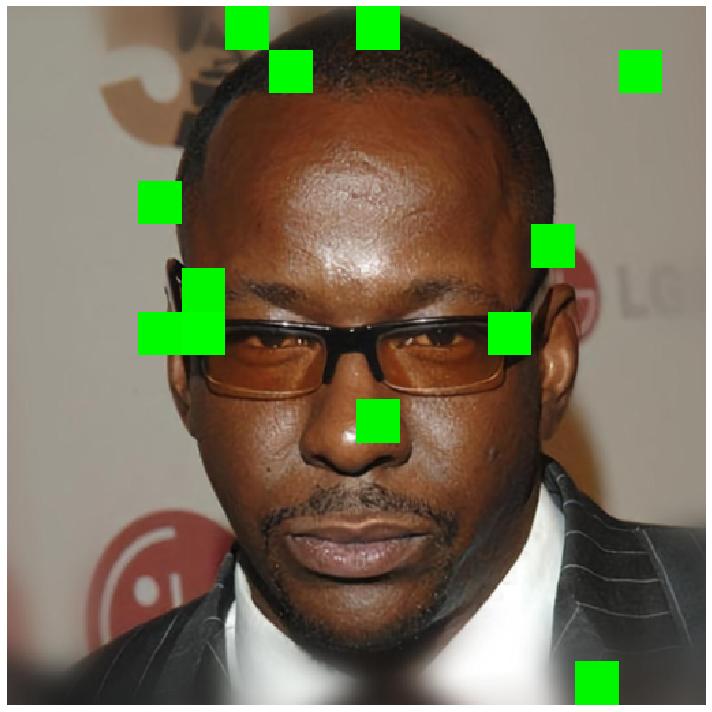

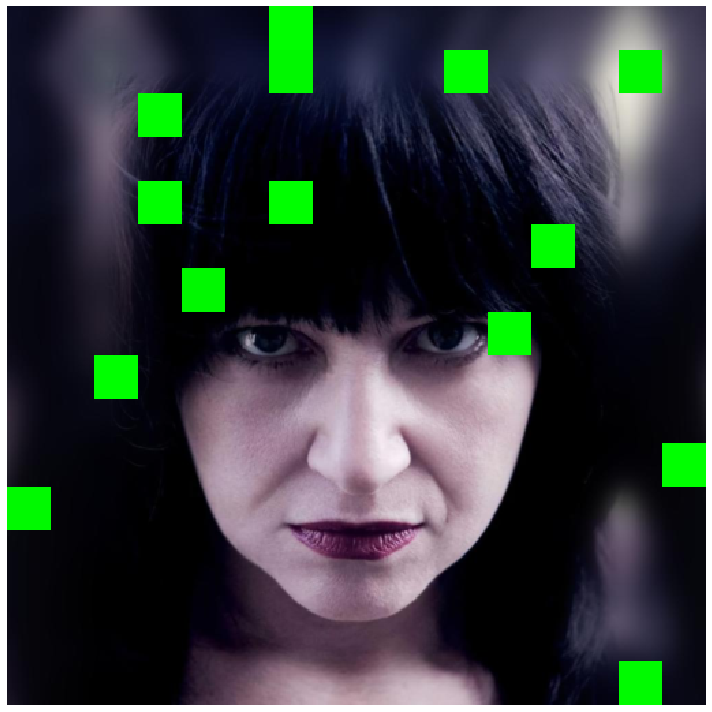

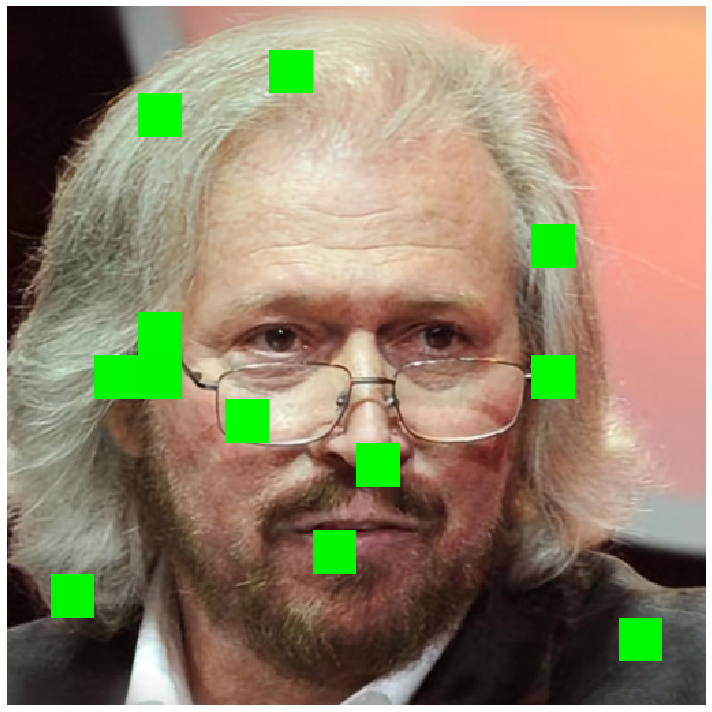

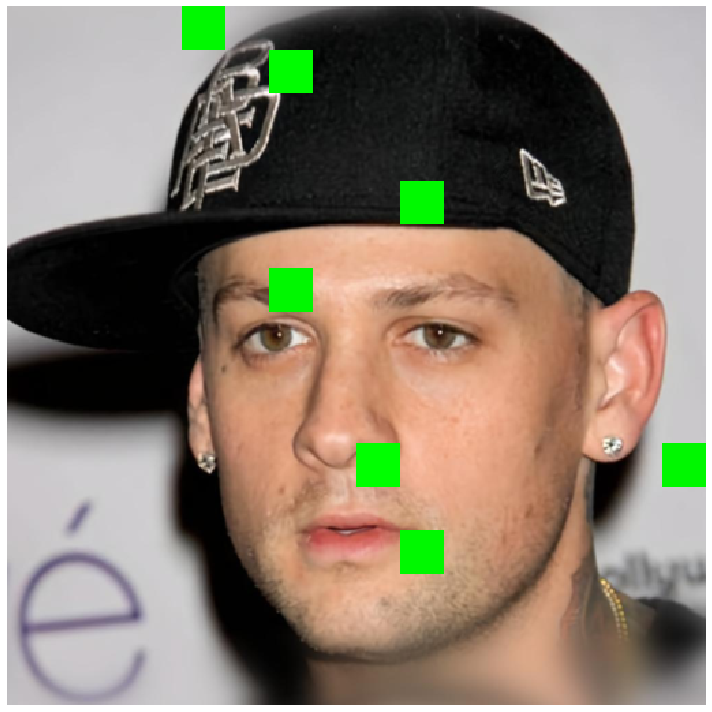

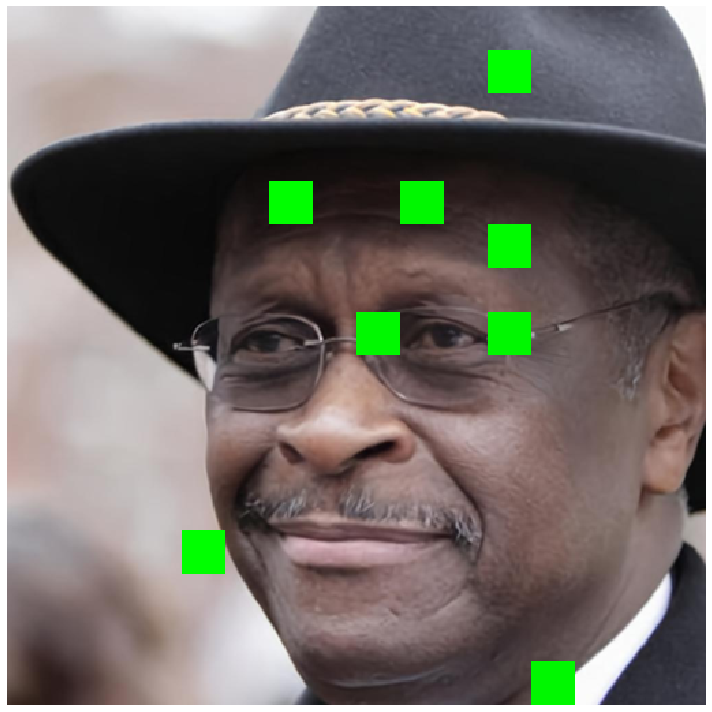

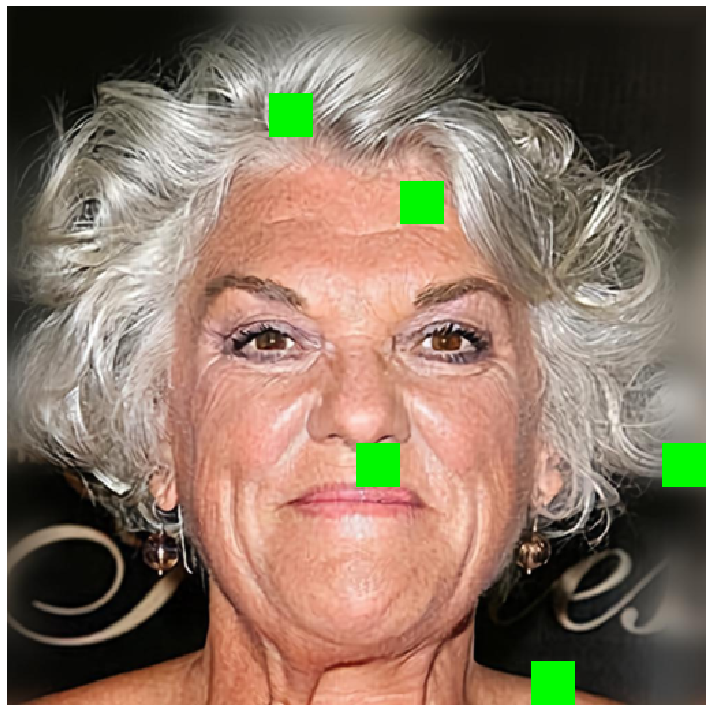

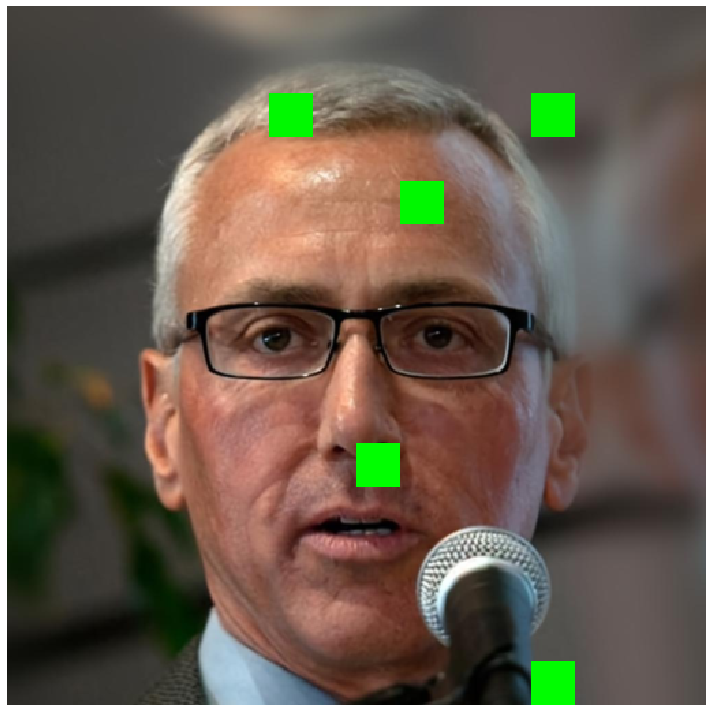

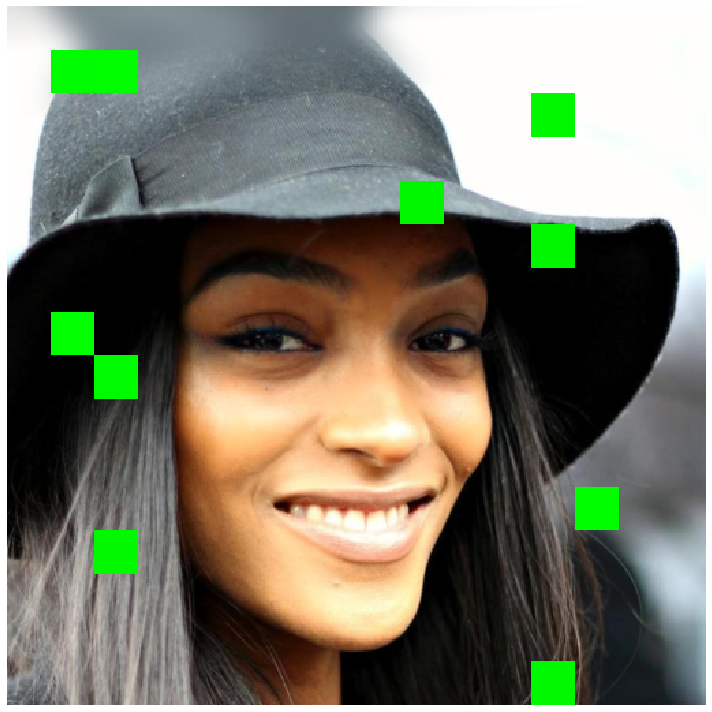

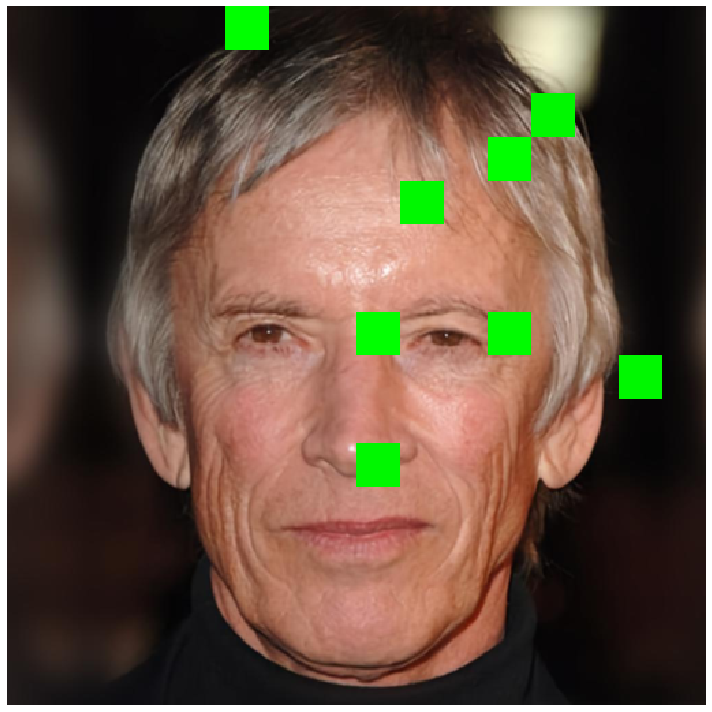

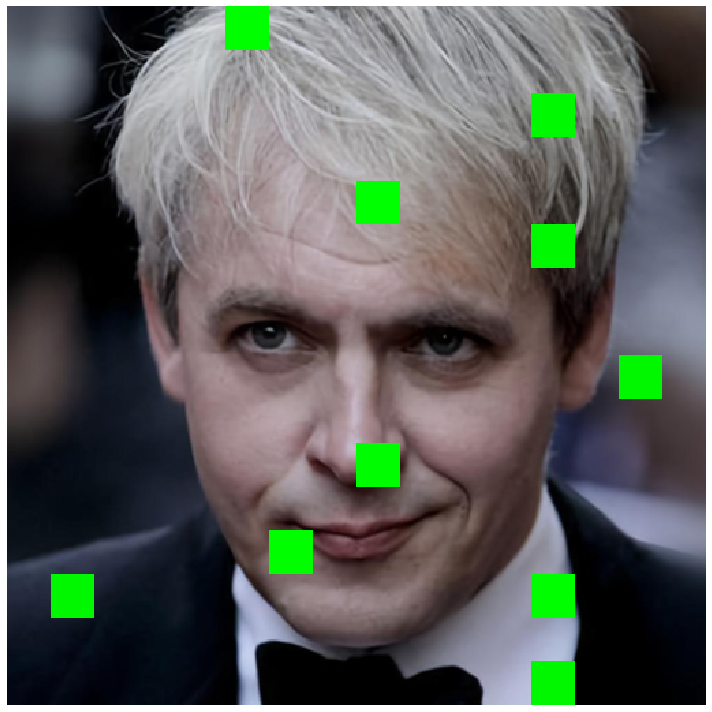

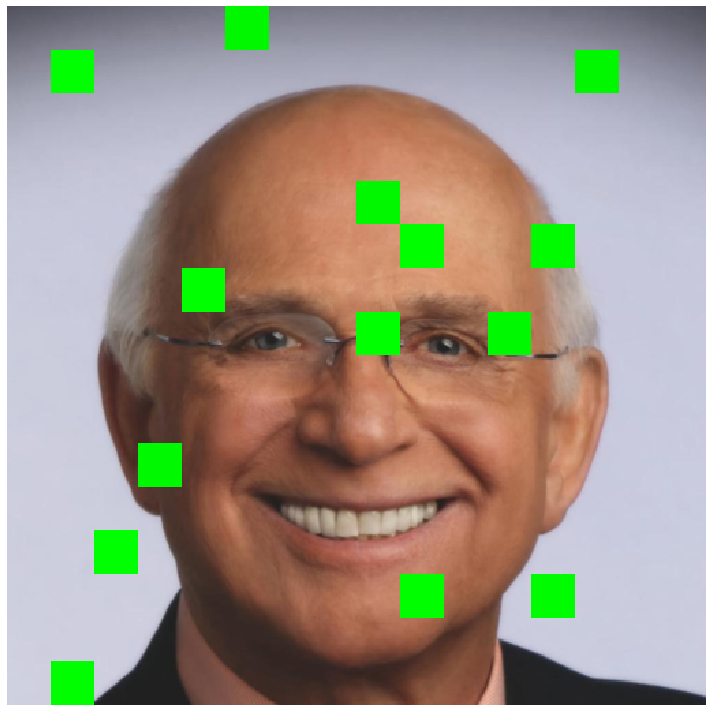

Error in callback <function flush_figures at 0x7f58bb4c5f80> (for post_execute):


KeyboardInterrupt: 

In [17]:
# Begin training model.
n_epochs = 250
for epoch in range(n_epochs):

    # Train the agent.
    train(agent, train_loader, epoch)
    
    # Test the agent.
    test(agent.policy, test_loader, epoch)